In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from tqdm.auto import tqdm
import sys
import glob
# import cmasher as cmr
from matplotlib import cm
import matplotlib as mpl

In [211]:
sys.path.append("/Users/pnr5sh/Documents/phd/mmmp/")
import sidchaini.sidhelpers as sidhelpers

In [212]:
#reading in meta data from sid's dir
header = ['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC', 'Obj. Type',
          'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)', 'From', 'Telescope',
          'Instrument', 'Observer/s', 'Reducer/s', 'Source group', 'Public', 'Associated groups',
          'End prop. period', 'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
          'Extinction-Corrected', 'WL Medium','WL Units', 'Flux Unit Coefficient', 'Spec. units',
          'Flux Calibrated By', 'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
          'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib', 'Publish', 'Remarks',
          'Created by', 'Creation date']
all_spec_meta = pd.read_csv('../sidchaini/1. download ALL wise data/wiserep_spectra_combined.csv', header='infer')
all_spec_meta.columns

Index(['wise_objid', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

In [213]:
#unique objs in all wiserep spec
all_spec_meta['Obj. Type'].unique()

array(['SN Ia', 'SN II', 'SN Ib', 'SN IIn', 'SN Ib/c', 'Other', 'M dwarf',
       'SN Ic-BL', 'SN IIP', 'SLSN-R', 'SN I-rapid', 'Varstar', 'Galaxy',
       'SLSN-I', 'SN Ic', 'SN IIL', 'SN Ia-pec', 'CV', 'SN Ia-91T-like',
       'SN IIb', 'LBV', 'SN IIn-pec', nan, 'WR-WN', 'SN Ia-CSM',
       'SN Ia-91bg-like', 'SN II-pec', 'SN', 'SN Iax[02cx-like]',
       'SN Ic-Ca-rich', 'TDE', 'SN Ibn', 'Gap', 'AGN', 'SN Ib-pec',
       'SLSN-II', 'SN I', 'ILRT', 'Nova', 'Impostor-SN', 'Computed-PISN',
       'WR-WC', 'Computed-IIP', 'Std-spec', 'TDE-He', 'SN Ia-Ca-rich',
       'Computed-Ia', 'SN Ib-Ca-rich', 'SN Ic-pec', 'SN Ia-SC',
       'SN Ib/c-Ca-rich', 'LRN', 'Computed-IIb', 'Afterglow', 'QSO',
       'Kilonova', 'SN Icn', 'Computed-IIn', 'Light-Echo', 'FBOT',
       'SN Ien', 'SN Ibn/Icn', 'FRB', 'TDE-H-He', 'Blazar', 'NA/Unknown'],
      dtype=object)

In [214]:
all_spec_meta['mjd'] = all_spec_meta['JD']-2400000.5

In [215]:
# filters for specific types
multi_types = ((all_spec_meta['Obj. Type']=='SN IIb')|(all_spec_meta['Obj. Type']=='SN Ib')|(all_spec_meta['Obj. Type']=='SN Ic')|
            #    (all_spec_meta['Obj. Type']=='SLSN-I')|(all_spec_meta['Obj. Type']=='SLSN-II')|(all_spec_meta['Obj. Type']=='SN IIn')|
               (all_spec_meta['Obj. Type']=='SN Ib/c')|(all_spec_meta['Obj. Type']=='SN Ic-BL')|(all_spec_meta['Obj. Type']=='SN Ic-Ca-rich')|
               (all_spec_meta['Obj. Type']=='SN Ibn')|(all_spec_meta['Obj. Type']=='SN Ib-Ca-rich')|(all_spec_meta['Obj. Type']=='SN Ic-pec')|
               (all_spec_meta['Obj. Type']=='SN Icn')|(all_spec_meta['Obj. Type']=='FBOT'))

#filters for ZTF/P60 data
p60 = (all_spec_meta['Telescope']=='P60')
sedm = (all_spec_meta['Instrument']=='SEDM')

In [238]:
# creating df of only objects meeting our target types, from ZTF 
mp_spec_df = all_spec_meta.loc[multi_types&p60&sedm]
print('No. of Unique Objs =', len(mp_spec_df['IAU name'].unique()))

#converting redshifts to floats
# pd.to_numeric(mp_spec_df['Redshift'], errors='coerce')

No. of Unique Objs = 195


In [315]:
mp_spec_df.loc[mp_spec_df['Created by']=='Yashvi Sharma']

,wise_objid,IAU name,Internal name/s,Obj. RA,Obj. DEC,Obj. Type,Redshift,Spec. ID,Obs-date,JD,...,Contrib,Publish,Remarks,Created by,Creation date,mjd,peak_mjd,peak_mag,peak_filt,double-peaked
125,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81324.0,2023-01-27 12:26:02.00,2.459972e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,59971.518079,60073.314592,16.781296,ZTF_g,1
126,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81325.0,2023-04-22 06:22:27.00,2.460057e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,60056.265590,60073.314592,16.781296,ZTF_g,1
127,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81326.0,2023-04-23 06:22:52.00,2.460058e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,60057.265880,60073.314592,16.781296,ZTF_g,1
128,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81328.0,2023-04-24 07:30:35.00,2.460059e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,60058.312905,60073.314592,16.781296,ZTF_g,1
129,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81330.0,2023-04-28 06:20:44.00,2.460063e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,60062.264398,60073.314592,16.781296,ZTF_g,1
130,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81333.0,2023-05-07 09:36:54.00,2.460072e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,60071.400625,60073.314592,16.781296,ZTF_g,1
131,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81335.0,2023-05-11 09:01:59.00,2.460076e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,60075.376377,60073.314592,16.781296,ZTF_g,1
132,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81336.0,2023-05-17 06:13:41.00,2.460082e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,60081.259502,60073.314592,16.781296,ZTF_g,1
133,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81338.0,2023-05-23 09:37:24.00,2.460088e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,60087.400972,60073.314592,16.781296,ZTF_g,1
134,22833.0,SN 2023aew,"ATLAS23dnr, Gaia23ate, ZTF23aaawbsc",265.214042,66.206319,SN IIb,0.025,81339.0,2023-06-08 04:24:56.00,2.460104e+06,...,NaN,NaN,NaN,Yashvi Sharma,2024-04-19 23:23:17,60103.183982,60073.314592,16.781296,ZTF_g,1


In [241]:
#just testing that we can plot the spectra

# for i in range(len(X)):
#     plt.figure()
#     plt.plot(wavelengths, X[i])
#     plt.xlabel('wavelength [A]')
#     plt.ylabel('normalized flux')
#     plt.title(f'{obj_names[i]}')

In [242]:
# types_str = ['SN IIb', 'SN Ib', 'SN Ic', 'SLSN-I', 'SLSN-II', 'SN IIn']
# types_flags = [iib, ib, ic, slsni, slsnii, iin]

# for i,types in enumerate(types_flags):
#     objs = all_spec_meta.loc[types&p60&sedm,'IAU name'].unique().tolist() #list of SN names

#     plt.figure(figsize=(9,7))
#     plt.xlabel('JD', fontsize=20)
#     plt.ylabel('Objs', fontsize=20)
#     plt.title(f'Date of spectra per object for {types_str[i]}', fontsize=20)

#     for j in range(len(objs)):
#         jds = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'JD'].array #JD of spectra taken for individ obj
#         plt.scatter(jds, [j]*len(jds), marker='.', s=150, label=f'{objs[j]} - {len(jds)}')

#     if len(objs)>26:
#         plt.legend(bbox_to_anchor=(1,1.0), frameon=False, ncol=2)
#     else:
#         plt.legend(bbox_to_anchor=(1,1.0), frameon=False, ncol=1)
#     plt.gca().invert_yaxis()

#     # plt.savefig(f'./figures/num_spec_for_{types_str[i]}.png', bbox_inches='tight')

In [243]:
# pd.set_option('display.max_rows', 50)

In [244]:
#read in all peak info files
#creates temp peak_mag df that drops repeated SN, keeps most updated SN/fit
# peak_mag is then concat'd to mp_spec_df

peak_files = glob.glob('./ztf_fp_data/peak_fit_*.txt')

peak_df = pd.DataFrame()
for file in peak_files:
    colnames = ['IAU name', 'peak_mjd', 'peak_mag', 'peak_filt']
    df = pd.read_csv(file, header=None, names=colnames, sep=' ', skiprows=1)
    if file[-8:-4]=='fbot':
        df['IAU name'] = 'AT '+df['IAU name'] #adding AT to match IAU standard in larger df
    else:
        df['IAU name'] = 'SN '+df['IAU name'] #adding SN to match IAU standard in larger df 

    # if verbose:
    #     print(df.loc[df['sn_name'].duplicated(), 'sn_name']) # names of objects that were duplicated
    df = df.drop_duplicates(subset=['IAU name'], keep='last', ignore_index=True) #only keep repeated names w/ highest index

    peak_df = pd.concat([peak_df,df],axis=0,ignore_index=True)

mp_spec_df = pd.merge(mp_spec_df, peak_df, on='IAU name', how='outer')

In [247]:
mp_spec_df['Phase (days)'] = mp_spec_df['mjd'] - mp_spec_df['peak_mjd']

In [249]:
mp_spec_df = mp_spec_df.loc[mp_spec_df['peak_mag'].notna()].reset_index(drop=True)

In [370]:
#NOTE: these lists contain SLSN+IIn objs that we have since ignored, will need to drop later

peak2_objs = ['2020adnx', '2020urc', '2023aew', '2023gwl', '2023psq', '2024zsw',
              '2020qlb', '2019tsf', '2019vsi', '2021hrj', '2019cad', '2019cri',
              '2020sgf', '2020xpn', '2022oqm', '2025aot', '2018hqm', '2019iay',
              '2019lkr', '2019qym', '2021bn', '2021uzt', '2024crf', '2025cbj',
              '2019kud', '2019hty', '2018avy', '2020bqj', '2019hgp']

bad_objs = ['2016exv', '2018hhs', '2018hoa', '201gaf', '2020jfv', '2020tjd',
            '2021adlr', '2021lwd', '2022acrz', '2023aew' '2020tcw', '2024dbb',
            '2019cqc', '2024hgx', '2018alc', '2018jgs', '2019bhh', '2019oys',
            '2020aaxs', '2020avf', '2020hqz', '2020ltq', '2020nac', '2021aghx',
            '2022ara', '2022bn', '2022jkx', '2023aaeg', '2023uvr', '2023ysu',
            '2023zms', '2024vrr', '2024zbl', '1996D', '2010ct', '2016flq',
            '2016ilg', '2017hbx', '2018oz', '2019nkf', '2019smi', '2019tqb',
            '2019yz', '2020hop', '2020nf', '2020rur', '2021adgu', '2021kwg',
            '2022abto', '2023aov', '2023apg', '2023bpv', '2023er', '2026fir',
            '2019alr', '2019jys', '2019mtk', '2019ssg', '2019wma', '2019wqc',
            '2020cke', '2020jhs', '2020nku', '2020onv', '2021adxl', '2021mz',
            '2021ulv', '2022waq', '2023alo', '2023emr', '2023jwb', '2024aboy',
            '2024lib', '2024yre', '2022mop', '2019pxu', '2018gwo', '2022S',
            '2021ttw', '2020aers', '2019oyj', '2019mbz', '2019fxo', '2018hnw',
            '2018hjx', '2018beh', '2016gkm', '2016dqt']

peak2_objs = ['SN '+sn for sn in peak2_objs]
bad_objs = ['SN '+sn for sn in bad_objs]

In [371]:
#one-hot encoding objects who are double-peaked (0=single, 1=double)
mp_spec_df['double-peaked'] = [0]*len(mp_spec_df)
mp_spec_df.loc[mp_spec_df['IAU name'].isin(peak2_objs), 'double-peaked'] = 1

In [372]:
print('No. of double-peaked objs =', len(mp_spec_df.loc[mp_spec_df['double-peaked']==1, 'IAU name'].unique()))

No. of double-peaked objs = 19


In [373]:
#dropping bad objs
mp_spec_df = mp_spec_df.loc[~(mp_spec_df['IAU name'].isin(bad_objs))].reset_index(drop=True)

In [374]:
#dropping SLSN-I/II, IIn objs which have 'nan' 'Obj. Types' from df
mp_spec_df = mp_spec_df.loc[~(mp_spec_df['Obj. Type'].isna())].reset_index(drop=True)

In [375]:
#checking to see if any objs have appear with mulitple different types
uniq_names = mp_spec_df['IAU name'].unique()

for sn in uniq_names:
    if len (mp_spec_df.loc[mp_spec_df['IAU name']==sn, 'Obj. Type'].unique())>1:
        print("WARNING: obj appears with multiple typings")

In [376]:
#defining specific type filters for the subselected df
iib = (mp_spec_df['Obj. Type']=='SN IIb')
ib = (mp_spec_df['Obj. Type']=='SN Ib')
ic = (mp_spec_df['Obj. Type']=='SN Ic')
# slsni = (mp_spec_df['Obj. Type']=='SLSN-I')
# slsnii = (mp_spec_df['Obj. Type']=='SLSN-II')
# iin = (mp_spec_df['Obj. Type']=='SN IIn')
ibc = (mp_spec_df['Obj. Type']=='SN Ib/c')
ibncn = (mp_spec_df['Obj. Type']=='SN Ibn')|(mp_spec_df['Obj. Type']=='SN Icn')
carich = (mp_spec_df['Obj. Type']=='SN Ib-Ca-rich')|(mp_spec_df['Obj. Type']=='SN Ic-Ca-rich')
fbot = (mp_spec_df['Obj. Type']=='FBOT')
icpec = (mp_spec_df['Obj. Type']=='SN Ic-pec')

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_37597/2969157187.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('plasma', len(sn_names))


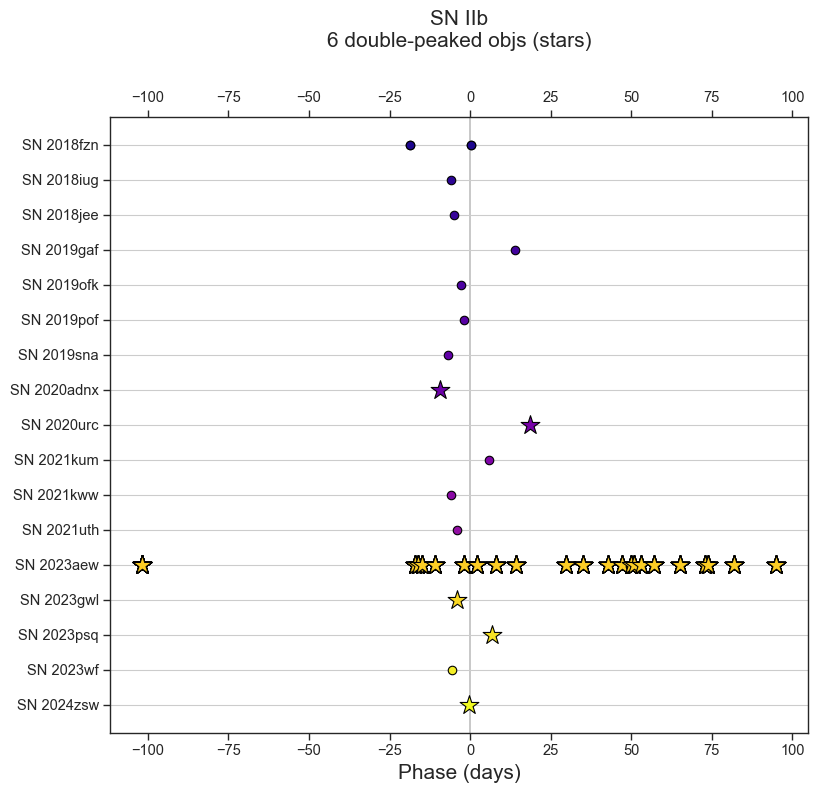

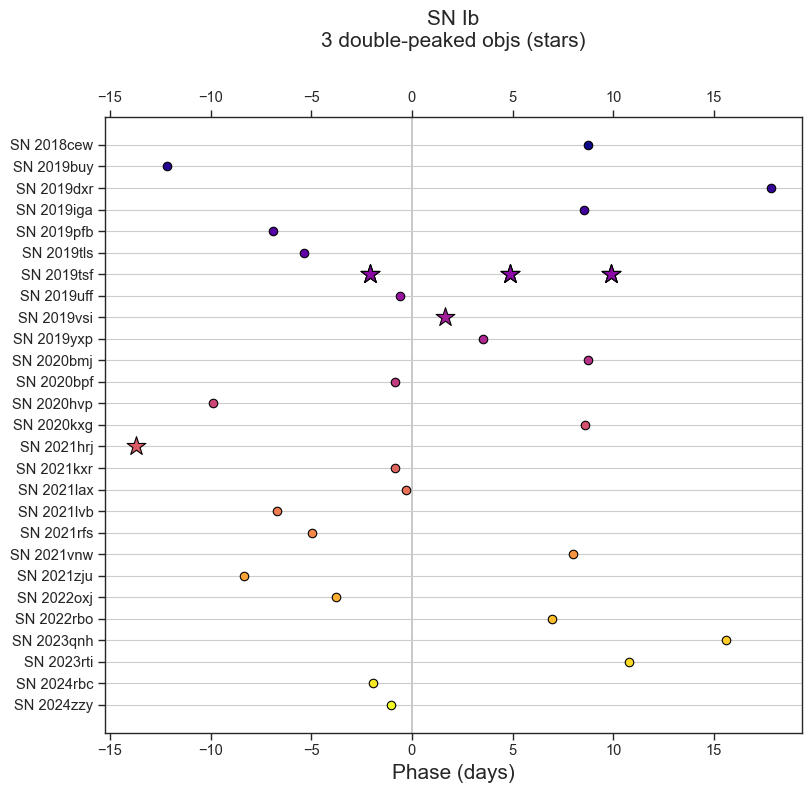

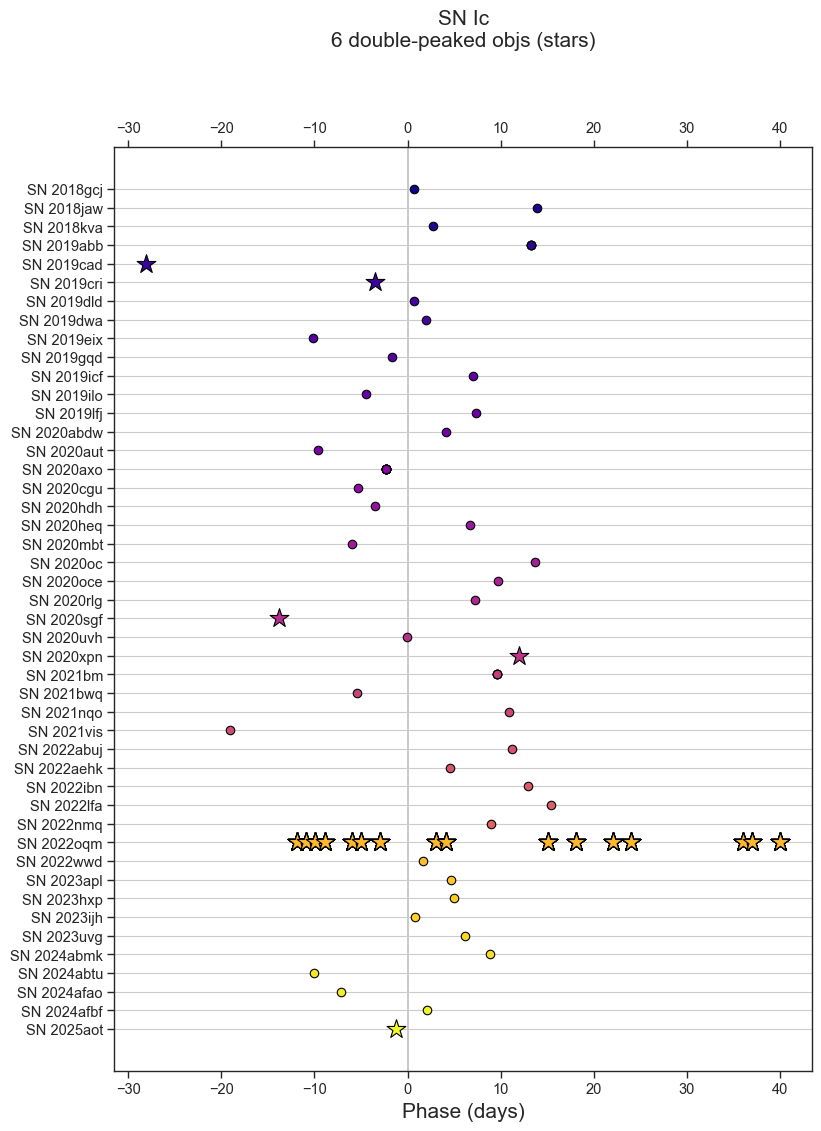

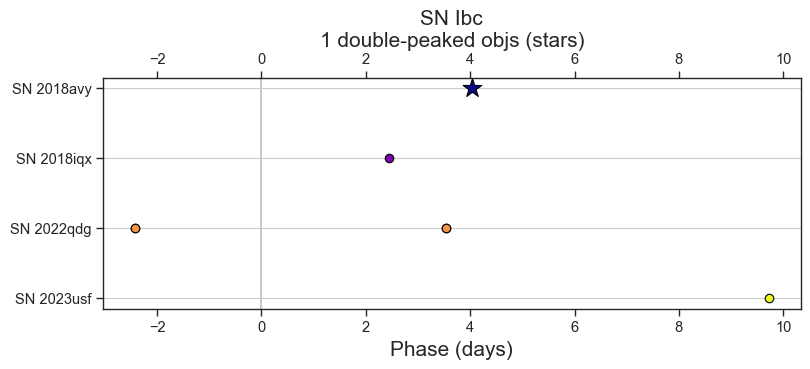

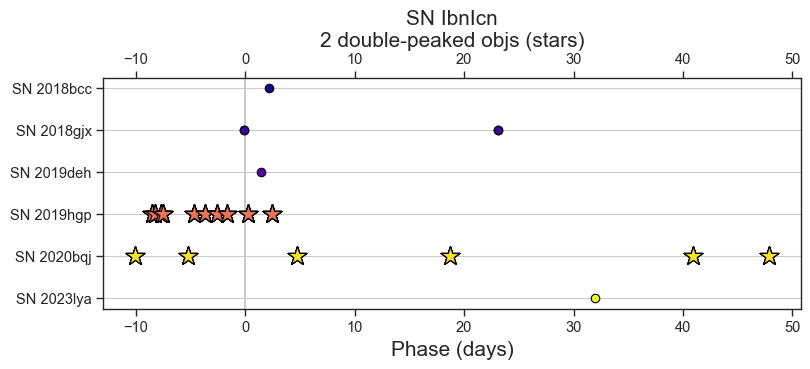

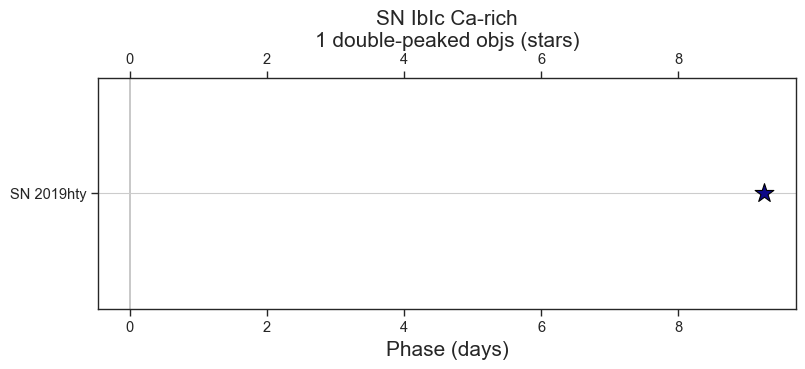

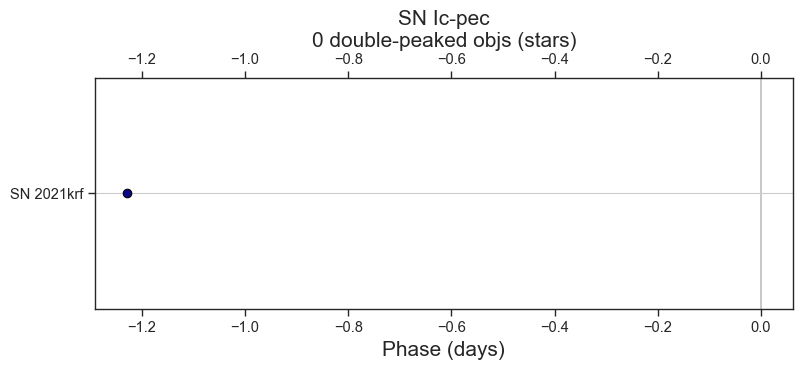

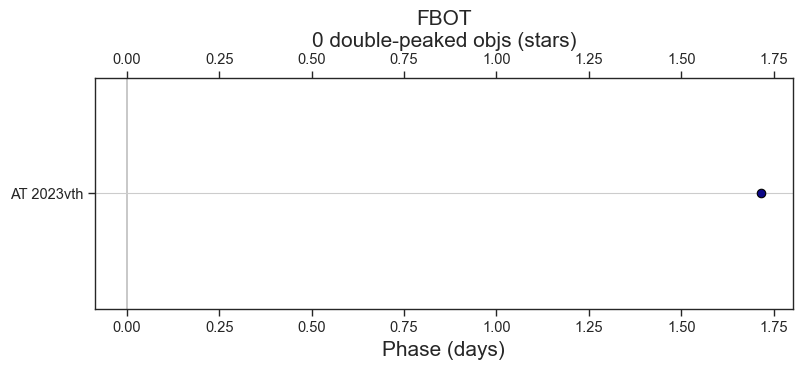

In [377]:
types_str = ['SN IIb', 'SN Ib', 'SN Ic', 'SN Ibc', 'SN IbnIcn', 'SN IbIc Ca-rich', 'SN Ic-pec', 'FBOT']
types_flags = [iib, ib, ic, ibc, ibncn, carich, icpec, fbot]

for i,types in enumerate(types_flags):
    # print(types_str[i], len(mp_spec_df.loc[types, 'IAU name'].unique()))
    # continue
    if len(mp_spec_df.loc[types, 'IAU name'].unique())<5:
        ylen = 2
    if len(mp_spec_df.loc[types, 'IAU name'].unique())<10:
        ylen = 3
    elif len(mp_spec_df.loc[types, 'IAU name'].unique())<30:
        ylen = 8
    elif len(mp_spec_df.loc[types, 'IAU name'].unique())<50:
        ylen = 12
    elif len(mp_spec_df.loc[types, 'IAU name'].unique())<70:
        ylen= 14

    fig = plt.figure(figsize=(9,ylen))
    ax1 = fig.add_subplot(111)

    sn_names = mp_spec_df.loc[types, 'IAU name'].tolist()
    viridis = cm.get_cmap('plasma', len(sn_names))
    test = [mpl.colors.to_hex(viridis.colors[i]) for i in range(len(sn_names))]
    # colors = [cm.to_hex(plt.cm.jet(i)) for i in range(len(sn_names))]
    sn_colors = dict(zip(sn_names,test))

    peak2objs = (mp_spec_df['double-peaked']==1)

    for j,sn in enumerate(sn_names):
        # print(sn)
        ax1.scatter(mp_spec_df.loc[types&(mp_spec_df['IAU name']==sn)&peak2objs, 'Phase (days)'],
                        mp_spec_df.loc[types&(mp_spec_df['IAU name']==sn)&peak2objs, 'IAU name'],
                        marker='*', s=200, edgecolor='black', facecolor=sn_colors.get(sn,'k'))
        ax1.scatter(mp_spec_df.loc[types&(mp_spec_df['IAU name']==sn)&~peak2objs, 'Phase (days)'],
                        mp_spec_df.loc[types&(mp_spec_df['IAU name']==sn)&~peak2objs, 'IAU name'],
                        marker='.', s=150, edgecolor='black', facecolor=sn_colors.get(sn,'k'))
    ax1.axvline(0, color='gray', zorder=0, alpha=0.5)

    ax1.set_xlabel('Phase (days)', fontsize=15)

    # ax2 = ax1.twiny()
    # ax2.scatter(mp_spec_df.loc[types, 'Phase (days)'], mp_spec_df.loc[types, 'IAU name'], marker='.', s=150)
    # ax2.set_xlabel('MJD fontsize=15)

    plt.gca().invert_yaxis()
    plt.gca().xaxis.grid(False)
    plt.gca().yaxis.grid(True)

    ax1.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)

    plt.title(f'{types_str[i]}\n{len(mp_spec_df.loc[types&peak2objs, 'IAU name'].unique())} double-peaked objs (stars)', fontsize=15, y=1.1)

    plt.savefig(f'./figures/phase_of_spec_for_{types_str[i]}_mp_denoted.png', bbox_inches='tight', dpi=300)

In [380]:
# mp_spec_df.loc[mp_spec_df['IAU name']=='SN 2018fzn', ['Phase (days)', 'Obs-date', 'mjd', 'peak_mjd', 'double-peaked']]

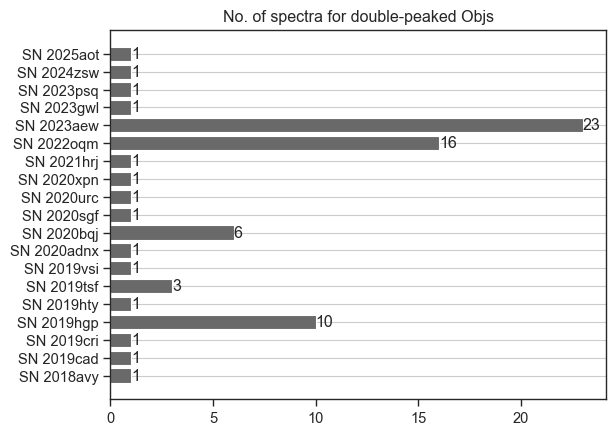

In [343]:
spec_no_dict={}

for sn in mp_spec_df.loc[mp_spec_df['double-peaked']==1, 'IAU name'].unique():
    instances = len(mp_spec_df.loc[(mp_spec_df['double-peaked']==1)&(mp_spec_df['IAU name']==sn)])
    spec_no_dict.update({sn: instances})

hbar = plt.barh(spec_no_dict.keys(), spec_no_dict.values(), color='dimgray')
plt.bar_label(hbar)
# plt.xticks(rotation=90)
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(True)
plt.title('No. of spectra for double-peaked Objs')
plt.savefig('./figures/num_spec_per_2peaked_obj.png', dpi=300, bbox_inches='tight')
#SN 2025aot shows no bar, but it had 1 spectra

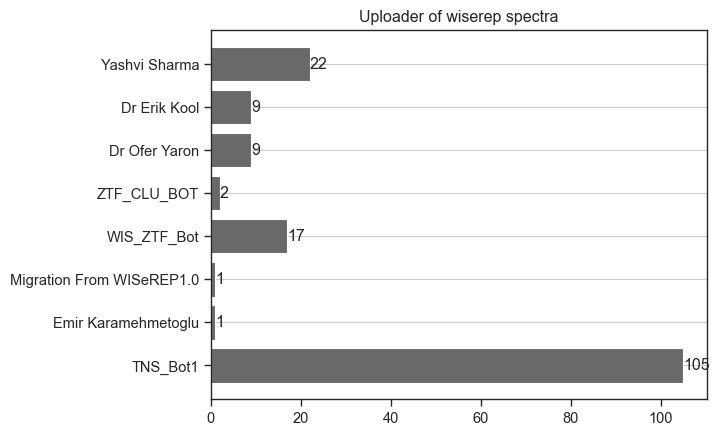

In [342]:
creator_dict={}

for creator in mp_spec_df['Created by'].unique():
    instances = len(mp_spec_df.loc[mp_spec_df['Created by']==creator])
    creator_dict.update({creator: instances})

hbar = plt.barh(creator_dict.keys(), creator_dict.values(),color='dimgray')# align='left', orientation='horizontal')
plt.bar_label(hbar)
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(True)
plt.title('Uploader of wiserep spectra')
plt.savefig('./figures/uploader_of_spectra_hist.png', dpi=300, bbox_inches='tight')